# Raman Analysis

## Setting up Python

### Importing necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit
import statistics
from ipywidgets import *

sys.path.append('Scripts')
from peak_fitting import *

#Setting up the notebook
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline
InteractiveShell.ast_node_interactivity = "none"

### Importing the data

In [47]:
def open_pickled_stats(name):
    infile = open(f"Data/pickled_for_stats/{name}_for_stats.pk", 'rb')
    data = pickle.load(infile)
    infile.close()
    return data
hmds = open_pickled_stats('hmds')
boot = open_pickled_stats('boot')
gs = open_pickled_stats('gs')
gl = open_pickled_stats('gl')
a4_multi = open_pickled_stats('a4_multi')
a4_double = open_pickled_stats('a4_double')
a4_single = open_pickled_stats('a4_single')
a6_multi = open_pickled_stats('a6_multi')
a6_double = open_pickled_stats('a6_double')
a6_single = open_pickled_stats('a6_single')
sample_dict = {'hmds':hmds, 'boot':boot, 'gs':gs, 'gl':gl, 'a4_multi':a4_multi, 
               'a4_double':a4_double, 'a4_single':a4_single, 'a6_multi':a6_multi,
               'a6_double':a6_double, 'a6_single':a6_single}

## Organisation of the data

The data for each type of sample is saved as a dictionary. The only important ones for the purpose of the analysis are 'data' and 'spectra'.

### The Raman spectra

Inputs: sample -> 'spectra' -> temperature

Outputs: list of spectra -> spectrum

To get the list of the Raman spectra for the hmds sample at 500 °C: use hmds['spectra'][500]. As this is a very long output the next cell only allows you to see how many spectra exist for different sample-temperature combinations.

In [3]:
def show_number_spectra(name, temperature):
    try:
        sample = sample_dict[name]
        n_samples = len(sample['spectra'][temperature])
        print(f'The sample {name} has {n_samples} Raman spectra taken at this temperature')
    except:
        print(f'There are no spectra available for {name} at {temperature}')
interact(show_number_spectra, name=list(sample_dict.keys()), temperature=[400, 500, 600, 700])

interactive(children=(Dropdown(description='name', options=('hmds', 'boot', 'gs', 'gl', 'a4_multi', 'a4_double…

Now from these spectra you can select which one you want to plot by adding a number: hmds['spectra'][500][1].
The spectra are saved as four columns pandas dataframe. This is because the Raman spectrometer wasn't set up to take a full Raman spectrum but instead two spectra centred around the G and 2D peaks.
Wavenumber1 and Intensity1 contain the D and G peaks, and Wavenumber2 and Intensity2 the 2D peak.

In [4]:
hmds['spectra'][500][1]

To access the data in each column you have to use yet another pair of brackets or a dot.

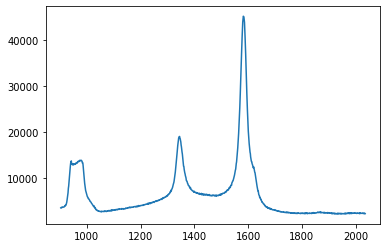

In [5]:
x = hmds['spectra'][500][1]['Wavenumber1']
y = hmds['spectra'][500][1].Intensity1
plt.plot(x,y)

### The peak data

All the spectra have been analysed previously, and the results saved so the computation does not need to be run again. They are avaible using sample['data'] and categorised by temperature as for the spectra.

In [6]:
def show_number_data(name, temperature):
    try:
        sample = sample_dict[name]
        n_samples = len(sample['data'][temperature])
        print(f'The sample {name} has {n_samples} analysed peak data at this temperature. This should correspond to the number of spectra.')
    except:
        print(f'There are no spectra available for {name} at {temperature}')
interact(show_number_data, name=list(sample_dict.keys()), temperature=[400, 500, 600, 700])

interactive(children=(Dropdown(description='name', options=('hmds', 'boot', 'gs', 'gl', 'a4_multi', 'a4_double…

The data is saved as Peak objects as from the peak_fitting.py script and can be accessed similarly to the spectra. They contain three dictionaries with the peak data, and two integers with the ID/IG and I2D/IG ratios.

In [7]:
peaks = hmds['data'][500][1]
peaks.d_peak
peaks.g_peak
peaks.d2_peak
peaks.id_ig
peaks.i2d_ig

## Functions for analysis

### Getting an average spectrum
Given a list of spectra, for instance hmds['spectra'][400], this returns an average

In [8]:
def get_average_spectrum(spectra):
    df = spectra[0]
    for spectrum in spectra:
        df = df.add(spectrum)
    df = df.divide(len(spectra)+1)
    return df

In [9]:
get_average_spectrum(hmds['spectra'][400])

### Statistical analysis of peak data

All the peak positions, widths and intensity have been analysed separately.

In [10]:
def get_data_stats(data):
    spec_peaks = ['d_peak', 'g_peak', 'd2_peak']
    all_peaks = {}
    spec_peaks_mean = []
    spec_peaks_dev = []
    spec_peaks_min = []
    spec_peaks_max = []
    spec_ratios = {}
    params = ["pos", "width", "intensity"]
    for peak in spec_peaks:
        peaks = [getattr(i, peak) for i in data]
        all_peaks[peak] = {j: [peak[j] for peak in peaks] for j in params}
        spec_peaks_mean.append({j: statistics.mean(all_peaks[peak][j]) for j in params})
        spec_peaks_dev.append({j: statistics.pstdev(all_peaks[peak][j]) for j in params})
        spec_peaks_min.append({j: min(all_peaks[peak][j]) for j in params})
        spec_peaks_max.append({j: max(all_peaks[peak][j]) for j in params})
    spec_mean = spec_data(*spec_peaks_mean)
    spec_dev = spec_data(*spec_peaks_dev)
    spec_min = spec_data(*spec_peaks_min)
    spec_max = spec_data(*spec_peaks_max)
    id_ig_s = [a/b for (a,b) in zip(all_peaks['d_peak']['intensity'], all_peaks['g_peak']['intensity'])]
    i2d_ig_s = [a/b for (a,b) in zip(all_peaks['d2_peak']['intensity'], all_peaks['g_peak']['intensity'])]
    spec_ratios['id_ig'] = {'mean': statistics.mean(id_ig_s), 'dev': statistics.pstdev(id_ig_s), 
                             'min': min(id_ig_s), 'max': max(id_ig_s)}
    spec_ratios['i2d_ig'] = {'mean': statistics.mean(i2d_ig_s), 'dev': statistics.pstdev(i2d_ig_s), 
                             'min': min(i2d_ig_s), 'max': max(i2d_ig_s)}
    return (spec_mean, spec_dev, spec_min, spec_max, spec_ratios)

The function has for input a list of peak objects and outputs the mean, deviation, minimum, and maximum as peak objects. It also outputs the  same values for the ratios in a dictionary.

In [11]:
mean, dev, minimum, maximum, ratios = get_data_stats(a4_double['data'][400])
mean.d_peak
dev.d_peak
minimum.d_peak
maximum.d_peak
ratios

## Plotting functions

### Change in peak data 

This function can plot the changes in position, width, or intensity against temperatures for all samples.

In [31]:
def plot_peak_change(ax, peak, param, *samples):
    ax.clear()
    #ts = get_overlap_ts(*samples)
    colors=["steelblue", "orangered", "chartreuse", "saddlebrown", 'purple', 'dimgrey']
    for i,sample in enumerate(samples):
        y = []
        y_error_lower = []
        y_error_upper = []
        y_error_dev = []
        y_error = {"dev": y_error_dev, "range":[y_error_lower, y_error_upper]}
        ts = list(sample["data"].keys())
        for t in ts:
            (spec_mean, spec_dev, spec_min, spec_max, spec_ratios) = get_data_stats(sample['data'][t])
            y_value = getattr(spec_mean,peak)[param]
            y_error_upper.append((-y_value+getattr(spec_max,peak)[param]))
            y_error_lower.append((y_value-getattr(spec_min,peak)[param]))
            y_error_dev.append(getattr(spec_dev,peak)[param])
            y.append(y_value)
        ax.errorbar([t+(i-1)*4 for t in ts], y, yerr=y_error["dev"], 
                     fmt='o-', ecolor='dimgrey', color=colors[i],
                     capsize=5, label=sample['name'], markersize=12, lw=2)
        ax.set_ylabel(param, fontsize=17)
        ax.set_xlabel('Temperature (°C)', fontsize=17)
        kwargs = dict(labelsize=15, pad=0.5, width=2, length=5, direction='out')
        ax.tick_params(**kwargs)
        ax.set_title(peak, fontsize=15)
        #print(sample['name'], y)
    ax.legend(fontsize=14)

For instance if you want to compare the G peak positions of the single layers of the two multilayers samples (a4_single and a6_single):

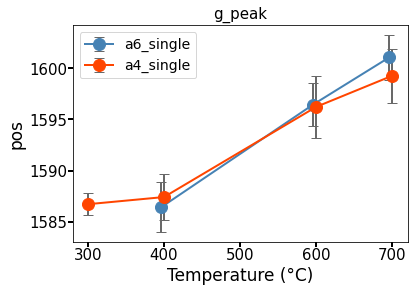

In [32]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
plot_peak_change(ax,'g_peak', 'pos', a6_single, a4_single)

Note that you can compare as many samples as you wish

### Changes in peak ratio

With a relatively similar function, the changes in peak ratios can be plotted.

In [14]:
def plot_ratio_change(ratio, *samples):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    #ts = get_overlap_ts(*samples)
    colors=["steelblue", "orangered", "chartreuse", "saddlebrown", 'purple', 'dimgrey']
    for i,sample in enumerate(samples):
        y = []
        y_error_lower = []
        y_error_upper = []
        y_error_dev = []
        y_error = {"dev": y_error_dev, "range":[y_error_lower, y_error_upper]}
        ts = list(sample["data"].keys())
        for t in ts:
            (spec_mean, spec_dev, spec_min, spec_max, spec_ratios) = get_data_stats(sample['data'][t])
            y_value = spec_ratios[ratio]['mean']
            y_error_upper.append((-y_value+spec_ratios[ratio]['max']))
            y_error_lower.append((y_value-spec_ratios[ratio]['min']))
            y_error_dev.append(spec_ratios[ratio]['dev'])
            y.append(y_value)
        ax.errorbar([t+(i-1)*4 for t in ts], y, yerr=y_error['range'], fmt='o-', 
                     ecolor='dimgrey', color=colors[i],
                     capsize=5, label=sample['name'], markersize=12, lw=2)
        ax.set_ylabel(ratio, size=17)
        ax.set_xlabel('Temperature (°C)', fontsize=17)
        kwargs = dict(labelsize=15, pad=0.5, width=2, length=5, direction='out')
        ax.tick_params(**kwargs)
        #plt.title(peak, fontsize=15)
        print(sample['name'], y)
    ax.legend(fontsize=14)

a6_single [0.24290790838952664, 0.2839394489532414, 0.2783295776324306]
a4_single [0.2519055580763359, 0.38977928694971925, 0.3895515244995993, 0.6099666546971827]


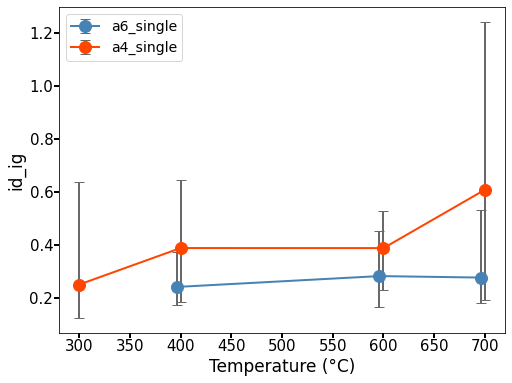

In [15]:
plot_ratio_change('id_ig', a6_single, a4_single)

### Comparison of G peak shift to 2D peak shift

Comparing the shift in G peak and 2D peak, it is possible to estimate the contributions of strain and doping to the change in the Raman spectrum.

In [16]:
def plot_peak_shifts(ts, *samples):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    markers = ['o', 'P', 'd', 'X']
    strain_shift = np.poly1d([2.1866773,-782.30125634])
    p_doping_shift = np.poly1d([6.96659036e-01,1.57483421e+03])
    ax.plot(1582, 2677, 'ko', markersize=10, label=None)
    X = np.linspace(1580, 1605, 100)
    ax.plot(X, strain_shift(X), 'k--', label="strain (Lee, J.E. et al)")
    ax.plot(X, p_doping_shift(X), 'r--', label="p-doping (Lee, J.E. et al)")
    for i,sample in enumerate(samples):
        if ts == "all":
            ts = sorted(list(set(sample["data"].keys())))
        #ts = [700]
        for t in ts:
            g_peaks = [getattr(i, 'g_peak')['pos'] for i in sample['data'][t]]
            d2_peaks = [getattr(i, 'd2_peak')['pos'] for i in sample['data'][t]]
            ax.plot(g_peaks, d2_peaks, markers[i], label=f"{sample['name']}: {t} °C")
    kwargs = dict(labelsize=15, pad=8, width=2, length=7, direction='out')#, labelrotation=20)
    ax.tick_params(**kwargs)
    ax.set_ylabel(r'2D peak position (cm$^{-1}$)', fontsize=17)
    ax.set_xlabel(r'G peak position (cm$^{-1}$)', fontsize=17)
    ax.set_ylim((2670, 2710))
    ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1))

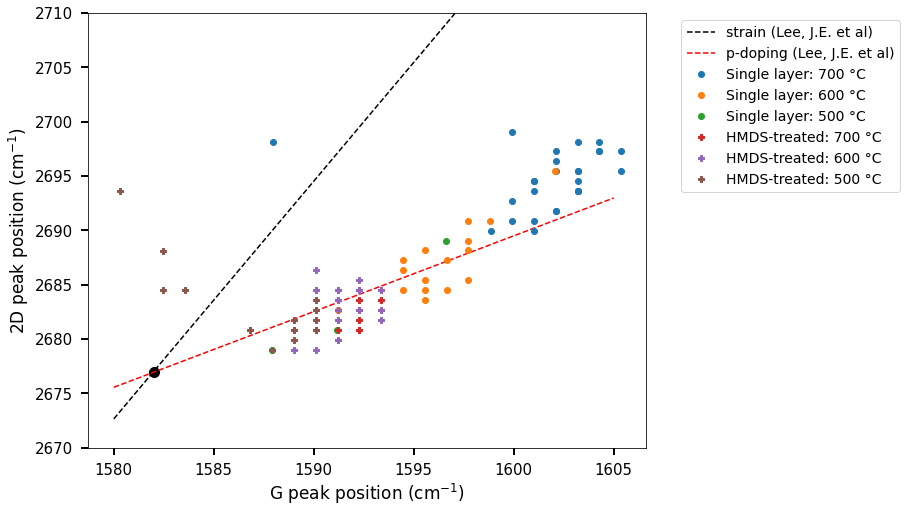

In [17]:
#boot['name'] = 'Single layer'  #This is just switching the sample names for better presentation
#hmds['name'] = 'HMDS-treated'
plot_peak_shifts([700, 600, 500], boot, hmds)

### Plotting multiple spectra

First by selecting a sample, and plotting the average spectra at all temperatures

In [18]:
def plot_spectra_by_temp(sample, height=1):
    fig = plt.figure(figsize=(10,7))
    (ax1, ax2) = fig.subplots(1, 2, sharey=True)
    isgold = True

    #get x and y
    background = {True: '_nb', False: ''}

    ts = [400, 600, 700]
    #samples = [boot, hmds, gs, gl, a6_double]#, a6_multi]
    #nbs = {sample['name']: background[sample['isgold']] for sample in samples}
    dfs = {t:get_average_spectrum(sample['spectra'][t]) for t in ts}
    #dfs = {sample['name']:get_average_spectrum(sample['spectra'][700]) for sample in samples}

    #plot
    i = 0
    for t,df in dfs.items():
        nb = background[sample['isgold']]
        area = df["Intensity1"+nb].sum()+df["Intensity2"+nb].sum()
        ax1.plot(df["Wavenumber1"], df["Intensity1"+nb]/area+i, lw=2.5)
        ax2.plot(df["Wavenumber2"], df["Intensity2"+nb]/area+i, lw=2.5)
        y = df["Intensity2"+nb]/df["Intensity2"+nb].sum()+i
        ax2.text(df["Wavenumber2"][300], y[300]+0.00001, f"{t} °C", fontsize=14)#, weight='bold')
        i += height*0.003

    d_peak = 1344
    g_peak = 1590
    d2_peak = 2682
    top = ax1.get_ylim()[1]*1.02
    ax1.axvline(x=g_peak, linestyle='--', color='grey')
    ax1.text(g_peak-80, top, 'G peak', fontsize=14)
    ax1.axvline(x=d_peak, linestyle='--', color='grey')   
    ax1.text(d_peak-80, top, 'D peak', fontsize=14)
    ax2.axvline(x=d2_peak, linestyle='--', color='grey')
    ax2.text(d2_peak-85, top, '2D peak', fontsize=14)

    ax1.set_xlim(1100, 1850)
    ax2.set_xlim(2350, 3100)
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    kwargs = dict(labelsize=15, pad=8, width=2, length=7, direction='out')#, labelrotation=20)
    ax1.tick_params(labelleft=None, left=None,**kwargs)
    ax2.tick_params(left=False,**kwargs)#, weight='bold')  # don't put tick labels at the top
    #ax2.xaxis.tick_bottom()
        
    d = .035  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False, lw=2)
    ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)        # top-left diagonal
    ax1.plot((1- d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((- d, + d), (- d,+ d), **kwargs)  # bottom-right diagonal
        
    fig.subplots_adjust(wspace=0.05)
    ax1.set_ylabel(r'Intensity (arb. units)', fontsize=17)
    fig.text(0.5, 0.005, r'Raman shift (cm$^{-1}$)', ha='center', fontsize=17)
    
    #ax2.legend(["400", "500", "600", "700"], loc='upper center', ncol=4)

    fig.show()

/home/anais/.local/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


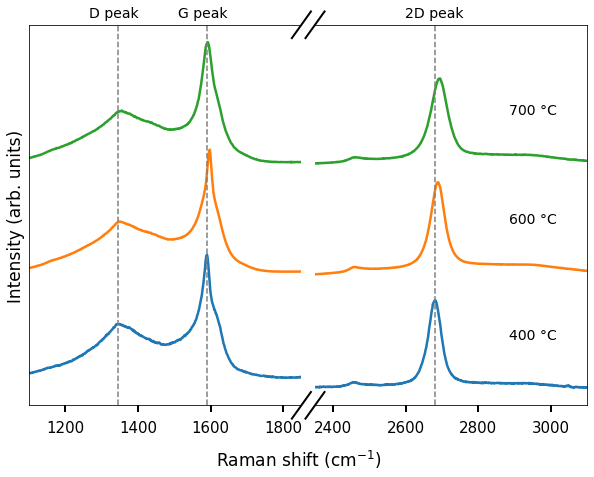

In [19]:
plot_spectra_by_temp(a6_double, height=0.5) #The height argument is used to ensure are separated by reasonable distances

# Interactive plots

## Changes in peak data

In [59]:
%matplotlib widget

#input widget for the samples
select_samples = widgets.SelectMultiple(
    options=list(sample_dict.keys()),
    value=['hmds'],
    description='Samples',
    disabled=False
)
display(select_samples)

# input widget for the peak
peak_toggle = widgets.ToggleButtons(
    options=[('D peak','d_peak'), ('G peak', 'g_peak'), ('2D peak','d2_peak')],
    description='Peak:')
display(peak_toggle)

# input widget for the property
prop_toggle = widgets.ToggleButtons(
    options=[('Width','width'), ('Position', 'pos'), ('Intensity','intensity')],
    description='Property:',
    button_style='')#, # 'success', 'info', 'warning', 'danger' or '')
display(prop_toggle)

#make plot responsive
def on_selection(_):
    samples = []
    for name in select_samples.value:
        samples.append(sample_dict[name])
    peak = peak_toggle.value
    prop = prop_toggle.value
    set_plot(peak, prop, *samples)
select_samples.observe(
    lambda c: on_selection(c['new']) if (c['type'] == 'change' and c['name'] == 'value') else None
)
peak_toggle.observe(
    lambda c: on_selection(c['new']) if (c['type'] == 'change' and c['name'] == 'value') else None
)
prop_toggle.observe(
    lambda c: on_selection(c['new']) if (c['type'] == 'change' and c['name'] == 'value') else None
)

#function to update plot
def set_plot(peak, prop, *samples):
    ax.clear()
    plot_peak_change(ax, peak, prop, *samples)
    #ax.clear()
    fig.canvas.draw()

fig = plt.figure()
ax = fig.add_subplot(111)
#set_plot('d_peak', 'pos')

plot_peak_change(ax, 'g_peak', 'pos', a6_single, a4_single)

SelectMultiple(description='Samples', index=(0,), options=('hmds', 'boot', 'gs', 'gl', 'a4_multi', 'a4_double'…

ToggleButtons(description='Peak:', options=(('D peak', 'd_peak'), ('G peak', 'g_peak'), ('2D peak', 'd2_peak')…

ToggleButtons(description='Property:', options=(('Width', 'width'), ('Position', 'pos'), ('Intensity', 'intens…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …